In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sns

# Loading the dataset
df = pd.read_excel(r"C:\Users\divya\OneDrive\Documents\SEM4\DAB400\Group 7\daily website fmt.xlsx")
df.head(5)

C:\Users\divya\AppData\Local\Temp\ipykernel_27000\3248086627.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Date,Unique Visits
0,9/14/2014,1582
1,9/15/2014,2528
2,9/16/2014,2630
3,9/17/2014,2614
4,9/18/2014,2366


In [2]:
# check the datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           2167 non-null   object
 1   Unique Visits  2167 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.0+ KB


In [4]:
# converting date to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
# check the datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           2167 non-null   datetime64[ns]
 1   Unique Visits  2167 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 34.0 KB


In [6]:
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]  # First 80% for training
test_df = df.iloc[train_size:]

In [7]:
# checking shape of data
train_data = train_df['Unique Visits'].values
test_data = test_df['Unique Visits'].values
print(train_data.shape)
print(test_data.shape)

(1733,)
(434,)


In [8]:
# define function to create samples with defined time_steps
def create_data(dataset, time_step):
  x,y=[],[]
  for i in range(len(dataset)):

    #end of current sequence
    end_step = i+time_step

    if end_step>len(dataset)-1: # check if we exceed lenght of dataset
      break

    seq_x = dataset[i:end_step] #sequence steps in 1 sample
    seq_y = dataset[end_step] # corresponding label i.e last value in sequence+1

    x.append(seq_x) # appending the samples in list
    y.append(seq_y) # appending their corresponding labels in list

    # returning numpy arrays
  return np.array(x),np.array(y)


In [9]:
# creating dataset of samples and features for training data
x_train, y_train = create_data(train_data,4)
print(x_train.shape,y_train.shape)

(1729, 4) (1729,)


In [10]:
# creating dataset of samples and features for test data
x_test, y_test = create_data(test_data,4)
print(x_test.shape,y_test.shape)

(430, 4) (430,)


In [11]:
# checking few training samples and their corresponding y label
for i in  range(6):
  print(x_train[i]," ",y_train[i])

[1582 2528 2630 2614]   2366
[2528 2630 2614 2366]   1863
[2630 2614 2366 1863]   1118
[2614 2366 1863 1118]   1656
[2366 1863 1118 1656]   2586
[1863 1118 1656 2586]   3257


In [12]:
# transform input from [samples, features] to [samples, timesteps, features]
X_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(X_train.shape)

X_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
print(X_test.shape)

(1729, 4, 1)
(430, 4, 1)


In [13]:
n_steps,n_features =4 ,1

In [14]:
# define the LSTM model
def create_model(optimizer,n_steps,n_features):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(n_steps, n_features)),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mae')
    return model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# fit model to the data
model = create_model('rmsprop',n_steps,n_features)

# defining callback for early stopping
#es = EarlyStopping(monitor='val_loss',verbose=1)
history = model.fit(X_train,y_train,epochs=100, validation_split=0.2 , verbose=0)

# Evaluate the model
test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores)

c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 - 0s - 3ms/step - loss: 238.3924
Test loss: 238.3924102783203


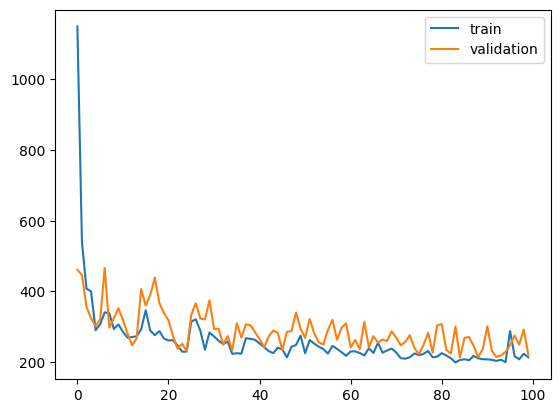

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_absolute_error

#make predictions and calculate MSE
test_predict = model.predict(X_test).flatten()
#calculate MSE
mean_absolute_error(y_test,test_predict)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


240.17639089185138

In [20]:
# Convert y_test and predictions to a DataFrame
results_df = pd.DataFrame({
    'y_test': y_test.flatten(),
    'predictions': test_predict
})

In [21]:
# Let's create a corresponding date range for our test dataset
test_dates = df.index[-len(y_test):]

# Add the dates to the results DataFrame
results_df['date'] = test_dates
results_df.set_index('date', inplace=True)

In [22]:
results_df.head(5)

,y_test,predictions
date,,
1737,2925,2688.600586
1738,3013,2938.785645
1739,2882,3009.948486
1740,2615,2797.983154
1741,2275,1952.704102


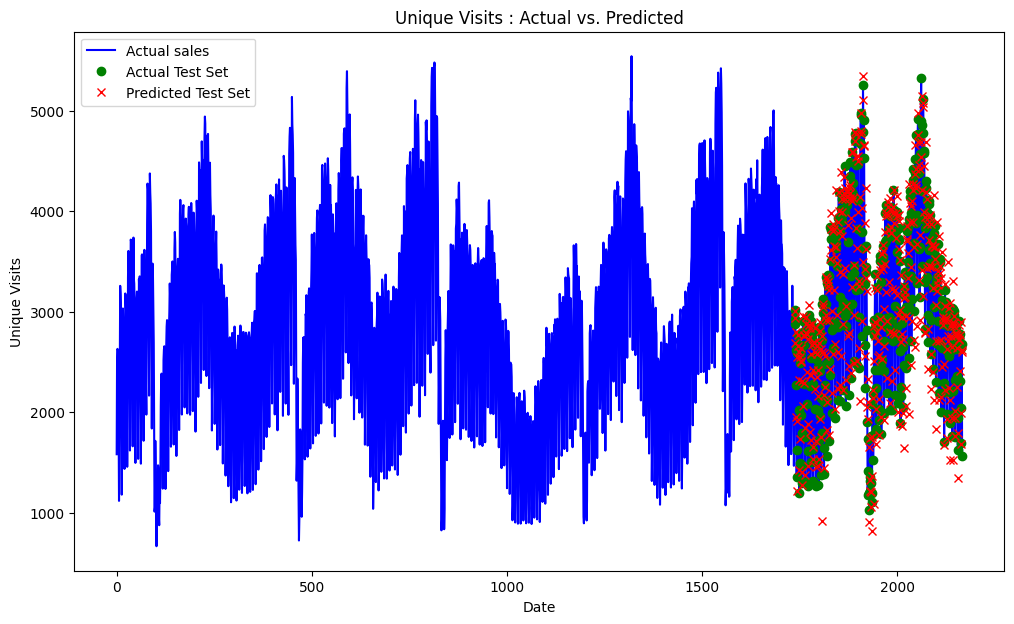

In [26]:
plt.figure(figsize=(12, 7))
plt.plot(df['Unique Visits'], label='Actual sales', color='blue')  # Original data
plt.plot(results_df['y_test'], label='Actual Test Set', marker='o', linestyle='None', color='green')
plt.plot(results_df['predictions'], label='Predicted Test Set', marker='x', linestyle='None', color='red')

plt.title('Unique Visits : Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Unique Visits')
plt.legend()
plt.show()